In [24]:
import pandas as pd
import numpy as np
import scipy as sp
import altair as alt
import matplotlib.pyplot as plt
import hashlib
from sklearn.model_selection import StratifiedShuffleSplit

ModuleNotFoundError: No module named 'pandas.tools'

In [4]:
#Environment Settings
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
alt.renderers.enable('notebook')
alt.data_transformers.enable('default', max_rows=None)
%matplotlib inline 
#this tells jupyter to use its own backend to display the matplotlib plot objects. 
#otherwise, we just get toStr() printouts for each plot!

RendererRegistry.enable('notebook')

DataTransformerRegistry.enable('default')

In [5]:
#Support Functions: 
def split_train_test(data, test_ratio,seed):
    np.random.seed(mySeed)
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

def test_set_check(identifier, test_ratio, hash):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio

def split_train_test_by_id(data, test_ratio, id_column, hash=hashlib.md5):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash))
    return data.loc[~in_test_set], data.loc[in_test_set]



In [6]:
#get the data:
calDF = pd.read_csv("./data/housing.csv")
calDF.head(5)
calDF.info()
calDF.shape

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


(20640, 10)

In [13]:
calDF.describe()
calDF["ocean_proximity"].value_counts()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f732165b198>,
      dtype=object)

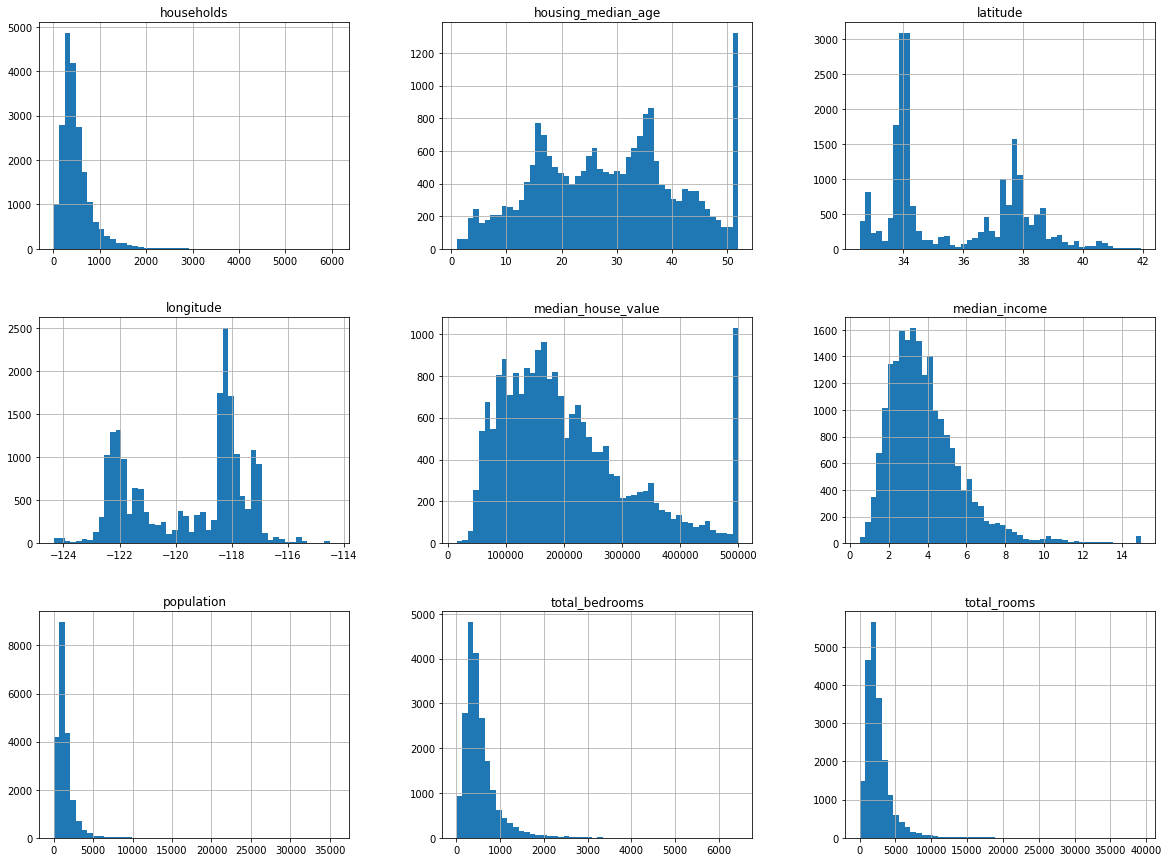

In [12]:
#it is easier to look at histograms (at least for me)
calDF.hist(bins=50,figsize=(20,15))
plt.show()

In [27]:
#We are about to start exploration and training on the data. Lets put aside a test set, and never look at it!
#This helps us avoid data dredging.
mySeed = 937
trainSet, testSet = split_train_test(calDF, 0.2,mySeed)
print(len(trainSet), "train +", len(testSet), "test")


16512 train + 4128 test


The above wont work if we update our dataset. If we rerun the partitioning again, our old test set will be shuffled into the training. Instead, we call a hash on the ID of each row, and if it is < 20% of last byte of the hash value, then it gets put into the test set. Hashes are random (but consistent in results), so we get back the same set. As our last byte distribution is expected to be fairly uniform, we expect about 20% of the new dataset to go into the test set as well. This is a decent solution.

In [7]:
#with this configuration, we need to append new data to the end of the data frame. 
housingWithId = calDF.reset_index()
trainSet, testSet = split_train_test_by_id(housingWithId, 0.2, "index")


Next we consider income catagories. We choose to place them in a discrete number of catagories, and sample from them. Our sampling here is stratified, and should be reflective of the distribution we are pulling from (we don't want too many or too little data in each catagory).

In [8]:
housingWithId["income_cat"] = np.ceil(housingWithId["median_income"] / 1.5) #make a new column with incomes catagories rounded up.
housingWithId["income_cat"].where(housingWithId["income_cat"] < 5, 5.0, inplace=True) #filter and replace all catagories, where the condition
#is FALSE!


In [10]:
#Our stratified sampling based on our income catagories.
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for trainIndex, testIndex in split.split(housingWithId, housingWithId["income_cat"]):
    stratTrainSet = housingWithId.loc[trainIndex]
    stratTestSet = housingWithId.loc[testIndex]


We are now going to start the data exploration phase. Lets make a copy of the stratTrainSet, and play around with it.

In [12]:
sTS = stratTrainSet.copy()

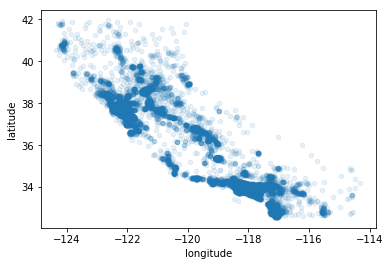

In [14]:
#first, lets look at the geogrphic distribution of data
#We see urban dense areas, and rural areas from the density in the plot.
sTS.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)


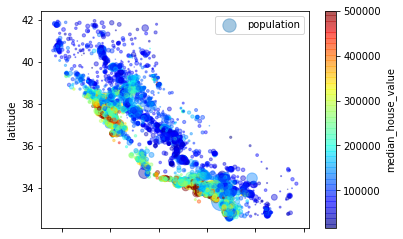

In [17]:
#Next we look at housing prices.
sTS.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
s=sTS["population"]/100, label="population",
c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True)
plt.legend()


We can see that the coast (central and south) has very high land value. There is also a central valley area 
that has some higher priced land. Next, lets look at all pairwise correlations between columns in our data frame.
This will give us a rough guide to what relationships to explore

In [18]:
corrMatrix = sTS.corr()

In [19]:
corrMatrix

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,income_cat
index,1.000000,-0.111913,0.079078,-0.181359,0.059255,0.027682,0.023079,0.026254,0.069915,0.067723,0.079346
longitude,-0.111913,1.000000,-0.924478,-0.105848,0.048871,0.076598,0.108030,0.063070,-0.019583,-0.047432,-0.016243
latitude,0.079078,-0.924478,1.000000,0.005766,-0.039184,-0.072419,-0.115222,-0.077647,-0.075205,-0.142724,-0.078848
housing_median_age,-0.181359,-0.105848,0.005766,1.000000,-0.364509,-0.325047,-0.298710,-0.306428,-0.111360,0.114110,-0.139385
total_rooms,0.059255,0.048871,-0.039184,-0.364509,1.000000,0.929379,0.855109,0.918392,0.200087,0.135097,0.221690
total_bedrooms,0.027682,0.076598,-0.072419,-0.325047,0.929379,1.000000,0.876320,0.980170,-0.009740,0.047689,0.012502
population,0.023079,0.108030,-0.115222,-0.298710,0.855109,0.876320,1.000000,0.904637,0.002380,-0.026920,0.022848
households,0.026254,0.063070,-0.077647,-0.306428,0.918392,0.980170,0.904637,1.000000,0.010781,0.064506,0.034995
median_income,0.069915,-0.019583,-0.075205,-0.111360,0.200087,-0.009740,0.002380,0.010781,1.000000,0.687160,0.902156
median_house_value,0.067723,-0.047432,-0.142724,0.114110,0.135097,0.047689,-0.026920,0.064506,0.687160,1.000000,0.642274


In [ ]:
Via inspection, we can see quite a few different correlates. Lets look at a few of them using the 
scatter matrix function:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4828ec0b38>,
      dtype=object)

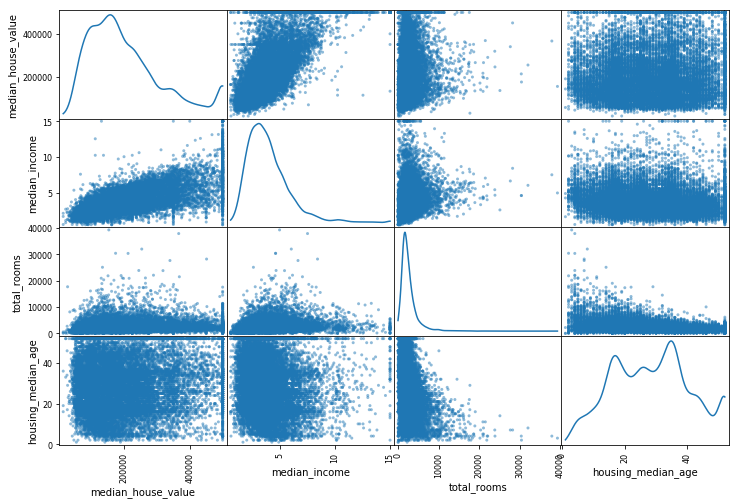

In [29]:
attributes = ["median_house_value", "median_income", "total_rooms","housing_median_age"]
pd.plotting.scatter_matrix(sTS[attributes], figsize=(12, 8),diagonal="kde")


Median House value vs Median Income seems to be the most promising. Lets examine it more closely

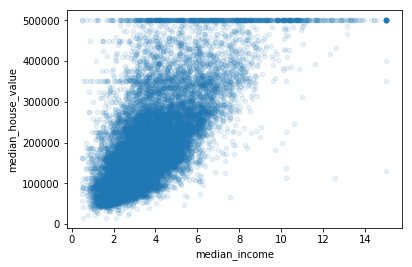

In [30]:
sTS.plot(kind="scatter", x="median_income", y="median_house_value",alpha=0.1)


The appropriate features to use are given to us by the book. As there is so much to learn, I won't do my own exploration, and continue with what the book says. Next, we need to Transform the Data so that it can be used for machine learning algorithms.

In [32]:
#Lets make another copy of the data 
housingDF = stratTrainSet.drop("median_house_value", axis=1) #along the cols
housingLabels = stratTrainSet["median_house_value"].copy()


In [41]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median") #note that code was refactored, SimpleImputer is new API standard.
housingNum = housingDF.drop("ocean_proximity", axis=1) #we can only impute numerical Catagories.
imputer.fit(housingNum)
imputer.statistics_
housingNum.median().values

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='median', verbose=0)

array([ 1.0341e+04, -1.1851e+02,  3.4260e+01,  2.9000e+01,  2.1195e+03,
        4.3300e+02,  1.1640e+03,  4.0800e+02,  3.5409e+00,  3.0000e+00])

array([ 1.0341e+04, -1.1851e+02,  3.4260e+01,  2.9000e+01,  2.1195e+03,
        4.3300e+02,  1.1640e+03,  4.0800e+02,  3.5409e+00,  3.0000e+00])

In [43]:
#Now that we have caluclated our medians to impute, lets transform.

X = imputer.transform(housingNum)

Next, we don't want to leave out the OceanProximity Column, so lets convert it to numbers and transform it:

In [48]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
housing_cat = housingDF["ocean_proximity"]
housing_cat_encoded = encoder.fit_transform(housing_cat)
housing_cat_encoded #Note: we don't have a series or DF here
print(encoder.classes_)



array([0, 0, 4, ..., 1, 0, 3])

['<1H OCEAN' 'INLAND' 'ISLAND' 'NEAR BAY' 'NEAR OCEAN']


In [ ]:
Now there is an issue with the above conversion. What if 2 and 4 correlate with high value, but the other numerical
catagories do not? This could cause problems with regression for example. It skews the fit. To solve this, we use 
OneHot Encoding. This creates a binary variable, which regression can handle. (??)

In [49]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1,1))
housing_cat_1hot


/home/user/Documents/Workspace/CodeProjects/Python3/DSDEenv/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>